In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import json
from math import floor, ceil

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


- Defining files path

In [3]:
ravdess_data = "/content/drive/MyDrive/ravdess"
JL_data = "/content/drive/MyDrive/JL_corpus"

- Defining dictionaries of emotions in each dataset and a list of emotions to hold

In [4]:
ravdess_emotions = {
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

observed_emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'anxious']

emotions_indeces = {
    'neutral': 0,
    'happy': 1,
    'sad': 2,
    'angry': 3,
    'fearful': 4,
    'anxious': 4,
}

- Defining static variables for audio processing

In [5]:
MAX_TIME = 130
EMO_NUM = 5
N_MFCCS = 13
SR = 22050

In [6]:
def effectif_ravdess():
    emotions = dict()
    actors = os.listdir(ravdess_data)
    for actor in actors:
        actor_dir = ravdess_data + "/" + actor
        sounds = os.listdir(actor_dir)
        for sound in sounds:
            emotion = ravdess_emotions[sound.split("-")[2]]
            if emotion in emotions:
                emotions[emotion] += 1
            else:
                emotions[emotion] = 1
    return emotions

def effectif_JL():
    emotions = dict()
    sounds = os.listdir(JL_data)
    for sound in sounds:
        emotion = sound.split("_")[1]
        if emotion in emotions:
            emotions[emotion] += 1
        else:
            emotions[emotion] = 1
    return emotions

In [7]:
print(effectif_ravdess())
print(effectif_JL())

{'disgust': 192, 'fearful': 192, 'angry': 192, 'calm': 192, 'neutral': 96, 'surprised': 192, 'sad': 192, 'happy': 192}
{'apologetic': 240, 'anxious': 230, 'assertive': 240, 'concerned': 240, 'encouraging': 240, 'excited': 240, 'happy': 230, 'neutral': 240, 'sad': 230, 'angry': 240}


In [8]:
def plot_mfcc(mfcc):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(np.array(mfcc).reshape([13, -1]), x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_soundwave(sound, sr):
    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(sound, sr)

In [10]:
def emotion2label(emotion):
    index = emotions_indeces[emotion]
    lst = [0 for n in range(index)] + [1] + [0 for m in range(EMO_NUM - index - 1)]
    return lst

def sound2feature(path):
    signal, sr = librosa.load(path, mono=True, duration=3, sr=SR)
    signal, index = librosa.effects.trim(signal)
    mfccs_ = librosa.feature.mfcc(y=signal, n_mfcc=N_MFCCS, sr=sr, n_fft=2048, hop_length=512)
    
    diff = (MAX_TIME - len(mfccs_[0])) / 2
    pre_pad = np.zeros((N_MFCCS, floor(diff)))
    post_pad = np.zeros((N_MFCCS, ceil(diff)))
    mfccs = np.concatenate((pre_pad, mfccs_,  post_pad), axis=1)
    mfccs = mfccs.reshape((1, -1))[0].tolist()
    return mfccs

- Plot signal and mfccs of a sound file from each dataset

In [11]:
rav_example = ravdess_data + "/Actor_04/03-01-05-02-02-02-04.wav"
jl_example = JL_data + "/female1_angry_7b_1.wav"

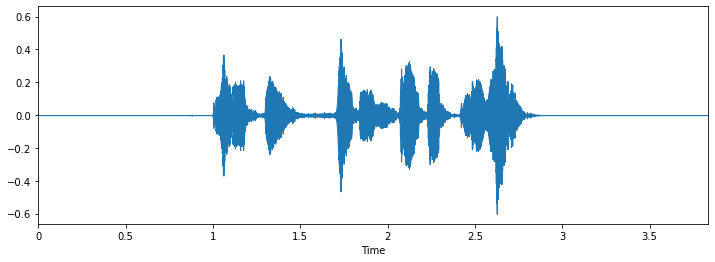

In [12]:
signal_1, sr = librosa.load(rav_example, SR)
plot_soundwave(signal_1, sr)

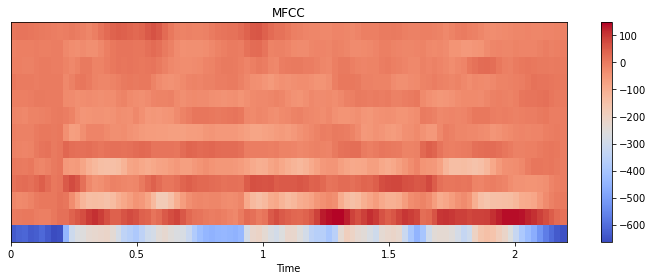

In [13]:
signal_1, index = librosa.effects.trim(signal_1)
mfccs = librosa.feature.mfcc(y=signal_1, n_mfcc=N_MFCCS, sr=sr, n_fft=2048, hop_length=512)
plot_mfcc(mfccs)

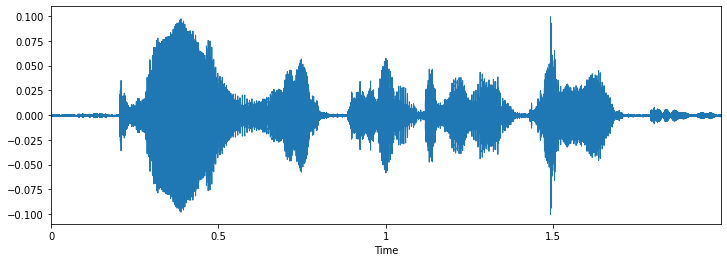

In [14]:
signal_2, sr = librosa.load(jl_example, SR)
plot_soundwave(signal_2, sr)

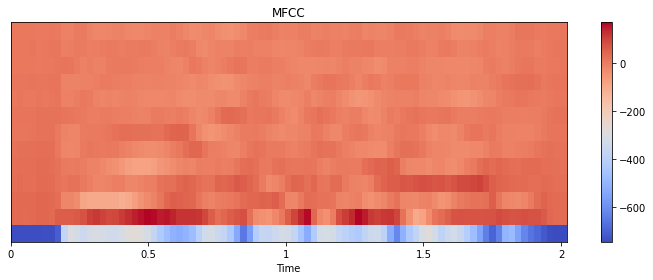

In [15]:
signal_2, index = librosa.effects.trim(signal_2)
mfccs = librosa.feature.mfcc(y=signal_2, n_mfcc=N_MFCCS, sr=sr, n_fft=2048, hop_length=512)
plot_mfcc(mfccs)

In [16]:
m = 0

def collect_ravdess(dir_path):
    global m
    data = []
    actors = os.listdir(dir_path)
    for actor in actors:
        actor_dir = ravdess_data + "/" + actor
        sounds = os.listdir(actor_dir)
        for sound in sounds:
            emotion = ravdess_emotions[sound.split("-")[2]]
            if emotion in observed_emotions:
                data.append({
                    "feature": sound2feature(actor_dir + "/" + sound),
                    "label": emotion2label(emotion)
                })
                print(sound, m)
                m += 1
    return data

def collect_JL(dir_path):
    global m
    data = []
    sounds = os.listdir(JL_data)
    for sound in sounds:
        emotion = sound.split("_")[1]
        if emotion in observed_emotions:
            data.append({
                "feature": sound2feature(dir_path + "/" + sound),
                "label": emotion2label(emotion)
            })
            print(sound, m)
            m += 1
    return data

In [17]:
data = []
data.extend(collect_ravdess(ravdess_data))
data.extend(collect_JL(JL_data))

03-01-06-02-02-01-19.wav 0
03-01-05-02-02-02-19.wav 1
03-01-01-01-01-01-19.wav 2
03-01-01-01-01-02-19.wav 3
03-01-06-01-01-01-19.wav 4
03-01-04-02-02-01-19.wav 5
03-01-06-01-01-02-19.wav 6
03-01-05-02-01-01-19.wav 7
03-01-06-02-01-01-19.wav 8
03-01-06-02-02-02-19.wav 9
03-01-04-02-02-02-19.wav 10
03-01-05-01-01-02-19.wav 11
03-01-03-01-01-01-19.wav 12
03-01-04-01-02-01-19.wav 13
03-01-04-02-01-02-19.wav 14
03-01-06-01-02-02-19.wav 15
03-01-05-02-02-01-19.wav 16
03-01-01-01-02-02-19.wav 17
03-01-05-01-02-02-19.wav 18
03-01-04-02-01-01-19.wav 19
03-01-03-02-02-02-19.wav 20
03-01-05-02-01-02-19.wav 21
03-01-06-02-01-02-19.wav 22
03-01-06-01-02-01-19.wav 23
03-01-03-02-01-01-19.wav 24
03-01-05-01-01-01-19.wav 25
03-01-03-01-01-02-19.wav 26
03-01-03-01-02-01-19.wav 27
03-01-03-02-01-02-19.wav 28
03-01-04-01-02-02-19.wav 29
03-01-03-02-02-01-19.wav 30
03-01-01-01-02-01-19.wav 31
03-01-05-01-02-01-19.wav 32
03-01-04-01-01-02-19.wav 33
03-01-04-01-01-01-19.wav 34
03-01-03-01-02-02-19.wav 35
03

In [20]:
print(len(data), len(data[0]["feature"]), len(data[0]["label"]))

2034 1690 5


In [22]:
path = "/content/drive/MyDrive/speech_emotion_data.json"
with open(path, "w") as f:
    json.dump(data, f)